# Michaelmas Mini-Project: World-Cup Simulation

## Import Libraries

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# this makes the results deterministic when we need to
seed = 31415

## Part One Section A: Introduction

### Question 1

Introduce two independent random variables
\begin{align}
G_A &\sim \text{Pois}(\lambda_A)\\
G_B &\sim \text{Pois}(\lambda_B)
\end{align}

Task: write a function to simulate result of a single game according to the Poisson model above

Input: $\lambda_A$ and $\lambda_B$

Output:
1. Number of goals scored by Teams A
2. Number of goals scored by Team B
3. Result (A - A won; B - B won; D - draw)

In [3]:
def single_game_result(lambdA, lambdB):
    # rng = np.random.default_rng(seed)
    A_goals = np.random.poisson(lambdA)
    B_goals = np.random.poisson(lambdB)
    if A_goals > B_goals:
        result = 'A'
    elif A_goals < B_goals:
        result = 'B'
    else:
        result = 'D'
    return [A_goals, B_goals, result]


Now, to record the results for 1000 games

In [4]:
lambdA = 1.5
lambdB = 2.0

A_list = [] # this list would be used to calculate the mean
for j in range(100):
    A_win = 0 # this initialize the tally
    for i in range(1000):
        if single_game_result(lambdA, lambdB)[2] == 'A':
            A_win += 1
    A_list.append(A_win)

std = np.std(A_list)
mean = np.mean(A_list)

# Now for a specific trial
trial = 0
for i in range(1000):
    if single_game_result(lambdA, lambdB)[2] == 'A':
        trial += 1

print('My estimate for the number of wins by Team A for this particular trial is', trial, 'wins. The mean of the simulation is', mean, 'wins and the standard deviation of the simulation is', std, 'wins, meaning that the likly accuracy of this particular trial is', (trial-mean)/std, 'standard deviations away from the mean')

My estimate for the number of wins by Team A for this particular trial is 280 wins. The mean of the simulation is 291.4 wins and the standard deviation of the simulation is 14.782421993705903 wins, meaning that the likly accuracy of this particular trial is -0.7711862105447874 standard deviations away from the mean


### Question 2

Task: generate dataset D containing results from 10 simulated matches between pairs of teams taken randomly from {W,X,Y,Z}

Note: two teams in each match are distinct; each team is involved in at least one match

Output: synthetic dataset in the form of a pandas data frame with columns `TeamA`, `TeamB`, `goalA`, `goalB`.

In [5]:
def generate_dataset(teams:list, lambd:list, N:int):
    column_names = ['Team A', 'Team B', 'goal A','goal B' ]
    index = np.arange(N)

    # first I will create an empty dataset with 10 rows and 4 columns

    df = pd.DataFrame(columns = column_names, index = index)

    # then I will simulate and record the result from each match, calling the function I defined previously

    for i in range(N):
        a_index, b_index = np.random.choice(len(teams), size = 2,replace = False)
        teamA, teamB = teams[a_index], teams[b_index]
        lambdA, lambdB = lambd[a_index], lambd[b_index]
        goalA, goalB = single_game_result(lambdA, lambdB)[:-1]
        df.loc[i,:] = [teamA, teamB, goalA, goalB]

    # lastly, I will re-run the simulation if any of the teams is not recorded in the results table

    for i in teams:
        if i not in df.loc[:,'Team A'].values and i not in df.loc[:,'Team B'].values:
            return generate_dataset(teams, lambd, N)

    #df.index += 1 #if needed for 1-indexed

    return df

In [6]:
teams = ['W', 'X', 'Y', 'Z']
lambd = [np.exp(1), np.exp(0.5), np.exp(0.75), np.exp(1.25)]
N = 10

In [7]:
results_table = generate_dataset(teams, lambd, N)
results_table

,Team A,Team B,goal A,goal B
0,X,Y,1,1
1,W,X,0,0
2,Z,Y,1,4
3,W,X,2,3
4,Z,W,2,3
5,X,Y,0,1
6,Z,Y,1,1
7,X,Y,1,4
8,X,W,2,1
9,W,Z,2,5


In [9]:
def mean_goal(teams,df):
    goal_dict = {}
    matches_dict = {}
    for i in set(teams):
        goal_dict[i] = 0
        matches_dict[i] = 0
    for j in df.index:
        teamA, teamB = df.iloc[j,:2]
        goal_dict[teamA] += df.iloc[j,2]
        goal_dict[teamB] += df.iloc[j,3]
        matches_dict[teamA] += 1
        matches_dict[teamB] += 1
    for key in goal_dict.keys():
        goal_dict[key] /= matches_dict[key]
    return goal_dict

In [10]:
mean_goals = mean_goal(teams,results_table)
mean_goals = sorted(mean_goals.items())
mean_goals = {k:v for k,v in mean_goals}
print('the mean goals scored were', mean_goals)

the mean goals scored were {'W': 1.6, 'X': 1.1666666666666667, 'Y': 2.2, 'Z': 2.25}


## Question 3

Given dataset D with N games, the $i^{th}$ game between Team $s_i$ and Team $t_i$ with score $u_i, v_i$ respectively,then the likelihood of obtain dataset D depending on parameters is given by
\begin{align}
L(D|(\lambda_W, \lambda_X, \lambda_Y, \lambda_Z)^T) &= \prod^N_{i=1} \left(\frac{\lambda_{s_i}^{u_i}\text{exp}(-\lambda_{s_i})}{(u_i)!}\right) \left(\frac{\lambda_{t_i}^{v_i}\text{exp}(-\lambda_{t_i})}{(v_i)!}\right)
\end{align}

Task:
1. Use `logpmf()` to calculate log likelihood function given dataset D & particular values of $\lambda_W, \lambda_X, \lambda_Y, \lambda_Z$
2. Use function `minimize()` to find maximum likelihood estimates of parameters $\lambda_W, \lambda_X, \lambda_Y, \lambda_Z$ for dataset D

In [11]:
import scipy.optimize as opt
import scipy.stats as stats

# first I would define this function to convert the data of a particular team to a list for the data to be processed
def extract_goals(df, team):
    team_df = pd.concat((df['goal A'][df['Team A'] == team],df['goal B'][df['Team B'] == team]))
    return team_df.to_list()


In [12]:
# Then I will define the log likelihood function
def log_likelihood(L, D): # L -> represents lambda; D -> represents dataset
    s=0
    for i in range(len(D)):
        s+=stats.poisson.logpmf(D[i], L)
    return s

# I will also define the log-transformation function to avoid optimizer going out of range

def log_transform(psi, D):
    L = np.exp(psi)
    return -1 * log_likelihood(L, D)

In [13]:
# Now I will perform the optimization, first storing the different number of goals scored by each team in a list of lists called dataset
dataset = []

for i in teams:
    dataset.append(extract_goals(results_table, i))
dataset


[[0, 2, 2, 3, 1], [1, 0, 1, 2, 0, 3], [1, 4, 1, 1, 4], [1, 2, 1, 5]]

In [14]:
poissonLL = []
Ls = []

for i in range(len(dataset)):
    w = opt.minimize(fun=log_transform, x0=0, args=dataset[i])

    if w.success:
        psi = w.x[0]
        L = np.exp(psi)
        print(f"Maximum likelihood estimate (Poisson model): lambda", str(teams[i]),f"={L:.2f}")
        print(f" psi={psi:.2f}; log likelihood={-1 * w.fun:.2f}")
        print(f" mean in dataset={np.mean(dataset[i]):.2f}")
        print(f" mean from model={L:.2f}")
    else:
        print("Optimisation failed")

    # store the lambdas
    Ls.append(L)

    # lastly store the log-likelihoods for calculation of AICc
    poissonLL.append(-1*w.fun)

Maximum likelihood estimate (Poisson model): lambda W =1.60
 psi=0.47; log likelihood=-7.42
 mean in dataset=1.60
 mean from model=1.60
Maximum likelihood estimate (Poisson model): lambda X =1.17
 psi=0.15; log likelihood=-8.41
 mean in dataset=1.17
 mean from model=1.17
Maximum likelihood estimate (Poisson model): lambda Y =2.20
 psi=0.79; log likelihood=-8.68
 mean in dataset=2.20
 mean from model=2.20
Maximum likelihood estimate (Poisson model): lambda Z =2.25
 psi=0.81; log likelihood=-7.18
 mean in dataset=2.25
 mean from model=2.25


Here, I would obtain the corrected AIC for the dataset

In [15]:
for i in range(len(poissonLL)):
    s = "Poisson"
    k=1
    LL = poissonLL[i]
    n = len(dataset[i])
    AIC = 2 * k - 2 * LL
    AICc = AIC + 2 * k * (k + 1) / (n - k - 1.1)
    print(teams[i], f": {s} k={k} LL={LL:.2f} AIC={AIC:.2f} AICc={AICc:.2f}")

W : Poisson k=1 LL=-7.42 AIC=16.84 AICc=18.22
X : Poisson k=1 LL=-8.41 AIC=18.81 AICc=19.84
Y : Poisson k=1 LL=-8.68 AIC=19.37 AICc=20.75
Z : Poisson k=1 LL=-7.18 AIC=16.36 AICc=18.47


Lastly, to visualize the dataset and the fitted model.

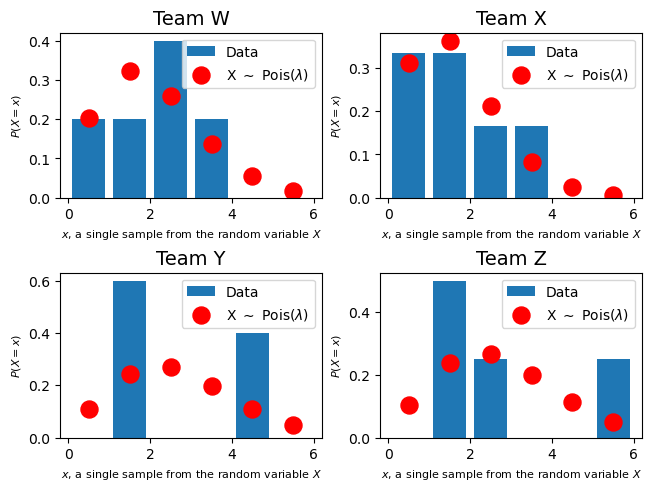

In [16]:
allX = np.array(range(6))
allXPlt = np.array(range(7))

def example_plot(ax,i):
    allY = stats.poisson.pmf(allX, Ls[i])
    ax.hist(dataset[i],bins=allXPlt,density=True,rwidth=0.8,label="Data")
    ax.scatter(allX+0.5,allY,color="red",s=150,label="X $\sim$ Pois($\lambda$)")
    ax.set_xlabel('$x$, a single sample from the random variable $X$', fontsize=8)
    ax.set_ylabel('$P(X = x)$', fontsize=8)
    ax.set_title('Team '+teams[i], fontsize=14)
    ax.legend()

fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)

i = 0
for ax in axs.flat:
    example_plot(ax,i)
    i += 1

## Question 4

Task: reshape dataset D to use stacked format and fit model using Poisson Regression

In [17]:
# first I will reshape the dataset

def reshape(df):
    reshaped = pd.DataFrame(columns = ['Team', 'Goals'],index = np.arange(len(df.index)*2))

    for i in df.index:
        reshaped.loc[2*i, 'Team'] = df.loc[i, 'Team A']
        reshaped.loc[2*i + 1, 'Team'] = df.loc[i, 'Team B']
        reshaped.loc[2*i, 'Goals'] = df.loc[i, 'goal A']
        reshaped.loc[2*i + 1, 'Goals'] = df.loc[i, 'goal B']

    return reshaped


In [18]:
teams_and_goals = reshape(results_table)

# first I will convert the teams into numerical values to avoid errors when passing into the GLM

teams_and_goals['Goals'] = pd.to_numeric(teams_and_goals['Goals'])

teams_and_goals

,Team,Goals
0,X,1
1,Y,1
2,W,0
3,X,0
4,Z,1
5,Y,4
6,W,2
7,X,3
8,Z,2
9,W,3


In [19]:
# Now, fitting the Poisson model as a generalized linear model
import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.glm(formula = 'Goals ~ Team',
                data = teams_and_goals,
                family = sm.families.Poisson()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Goals   No. Observations:                   20
Model:                            GLM   Df Residuals:                       16
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31.689
Date:                Sat, 07 Jan 2023   Deviance:                       20.928
Time:                        10:29:47   Pearson chi2:                     18.8
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1152
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4700      0.354      1.329      0.1

In [20]:
est_lambdW = np.exp(model.params[0])
est_lambdX = np.exp(model.params[1]+model.params[0])
est_lambdY = np.exp(model.params[2]+model.params[0])
est_lambdZ = np.exp(model.params[3]+model.params[0])
print('the estimated values for lambda for W, X, Y, Z are ', est_lambdW, est_lambdX, est_lambdY, est_lambdZ, 'respectively, which is identical to the results of mean scoring rate obtained previously')


the estimated values for lambda for W, X, Y, Z are  1.60000000000048 1.1666666666976857 2.2000000000131275 2.2500000000390252 respectively, which is identical to the results of mean scoring rate obtained previously


## Question 5

Assume that if Team $k$ is ranked $r_k$, then the natural logarithm of mean number of goals per match scored by Team $k$ depends linearly on its rank via
\begin{align}
\text{log}(\lambda_k) = \alpha + \beta r_k
\end{align}

We know that
\begin{align}
r_W &= 2\\
r_X &= 4\\
r_Y &= 3\\
r_Z &= 1
\end{align}

Task:
1. Update the stacked dataframe to include column `Rank` and use poisson regression to fit model `Goals ~ Rank` to dataset D
2. Report estimates of $\alpha, \beta$ and AICc of the fitted model
3. Include scatter graph, one point per team, showing rank on x-axis and logarithm of goal scoring rate on y-axis. Add line corresponding to fitted values of $\alpha$ and $\beta$ to the graph.
4. Explain how it shows the fitted values of $\alpha$ and $\beta$ are consistent with results from 3 and 4
5. Which models fitted is the most parsimonious

In [21]:
def update_stack(df):
    rank = [2,4,3,1]
    for i in df.index:
        df.loc[i,'Rank'] = rank[teams.index(df.loc[i, 'Team'])]
    return df

In [22]:
teams_and_goals = reshape(results_table)
teams_rank_goals = update_stack(teams_and_goals)
teams_rank_goals['Rank'] = teams_rank_goals['Rank'].astype(int)
teams_rank_goals['Rank'] = pd.to_numeric(teams_rank_goals['Rank'])
teams_rank_goals['Goals'] = pd.to_numeric(teams_rank_goals['Goals'])

In [23]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

model = smf.glm(formula = 'Goals ~ Rank',
                data = teams_rank_goals,
                family = sm.families.Poisson()).fit()

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Goals   No. Observations:                   20
Model:                            GLM   Df Residuals:                       18
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -32.386
Date:                Sat, 07 Jan 2023   Deviance:                       22.321
Time:                        10:29:52   Pearson chi2:                     20.5
No. Iterations:                     4   Pseudo R-squ. (CS):            0.05135
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9580      0.410      2.337      0.0

Now plotting the scatter graph of logarithm of goal scoring rate against the rank

In [24]:
# I will then store the values of parameters for plotting
params = model.params
alpha = params[0]
beta = params[1]

In [26]:
lambd = np.array([est_lambdW, est_lambdX, est_lambdY, est_lambdZ])
rank = np.array([2,4,3,1])
log_rate = np.log(lambd)
log_rate

array([0.47000363, 0.15415068, 0.78845736, 0.81093022])

Text(0, 0.5, 'Log of goal scoring rate')

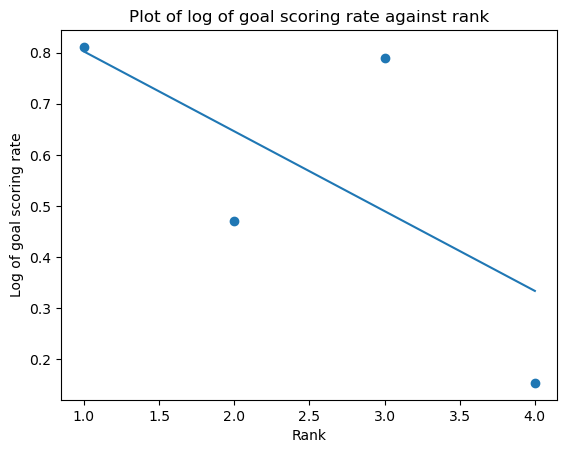

In [27]:
# now, plotting the scatter plot AND the plot of predicted fit
x = np.linspace(1,4,100)
y = alpha + beta*x

fig, ax = plt.subplots()
ax.scatter(rank, log_rate)
ax.plot(x,y)
ax.set_title('Plot of log of goal scoring rate against rank')
ax.set_xlabel('Rank')
ax.set_ylabel('Log of goal scoring rate')

## Part One Section B

### Question 6

Assume that goal scoring rate for team $k$ follows
\begin{align}
\text{log}(\lambda_k)&= \alpha + \beta r_k
\end{align}
where $r_k$ is the team's ranking, let $\alpha = 1$, $\beta = -0.05$.

Task
1. Simulate World Cup as a knockout tournament between 32 teams using Poisson model with $\lambda_k$ as the goal scoring rate of $k^{th}$ team

KEY: print details of single example tournament

2. Run code 1000 times and estimate the probability of each team winning the entire tournament



In [28]:
teams_df = pd.read_csv('Datasets/2022_teamID.csv')
rank_df = pd.read_csv('Datasets/2022_rankings.csv')

In [29]:
print(teams_df.head())

  Group  ID         Team Home
0     A   1        Qatar  Yes
1     A   2      Ecuador   No
2     A   3      Senegal   No
3     A   4  Netherlands   No
4     B   1      England   No


In [30]:
print(rank_df.head())

        Team  Rank  Rating  Unnamed: 3  Unnamed: 4  Unnamed: 5
0     Brazil   1.0  1841.0         NaN         NaN         NaN
1    Belgium   2.0  1817.0         NaN         NaN         NaN
2  Argentina   3.0  1774.0         NaN         NaN         NaN
3     France   4.0  1760.0         NaN         NaN         NaN
4    England   5.0  1728.0         NaN         NaN         NaN


In [31]:
# First, I will define how the score rate is calculated
def score_rate(ranking, alpha = 1, beta = -0.05):
    return np.exp(alpha + beta * ranking)

In [32]:
# I will then merge the two dataframes on country and perform some data cleaning
combined = pd.merge(rank_df, teams_df,how = 'outer', on = 'Team')
combined = combined[['Team', 'Rank', 'Rating', 'Group', 'ID', 'Home']]
qualified = combined.dropna(subset=['Group']) #lastly I will only select the teams that are qualified in the world cup
len(combined), len(qualified)

(73, 32)

In [33]:
# now, I will then add a column that denotes the goal scoring rate based on calculations from each team's ranking
qualified['Goal Rate'] = score_rate(qualified['Rank'])

/var/folders/yb/bffvyrdd7gn289hkvgkcldn40000gn/T/ipykernel_60044/1089179734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['Goal Rate'] = score_rate(qualified['Rank'])


For simplicity due to this particular question, I will only keep the columns 'Teams' and 'Goal Rate' since they are what matters if this is a simple knockout tournament

In [34]:
round_32 = qualified[['Team', 'Goal Rate']]

Recall that I have previously defined the function `single_game_result` that pass in the arguments `lambdA, lambdB` and returns the list `[goalA, goalB, result]`, ie predicted goals scored by each team and the final result (A - A win; B - B win; D - draw)

In [35]:
# First I would randomly allocate the 16 pairs by generating the 32 numbers from 0 to 31, with each two consecutive numbers denoting a pair

pairs_32 = np.random.choice(32,32,replace=False) # using replace = False I make sure that no pair is repeated
for i in range(1, len(pairs_32),2):
    print('assigned pairs', (pairs_32[i-1], pairs_32[i]))

assigned pairs (23, 5)
assigned pairs (30, 12)
assigned pairs (2, 1)
assigned pairs (13, 0)
assigned pairs (17, 6)
assigned pairs (24, 29)
assigned pairs (14, 28)
assigned pairs (22, 8)
assigned pairs (31, 9)
assigned pairs (21, 11)
assigned pairs (4, 25)
assigned pairs (15, 3)
assigned pairs (26, 19)
assigned pairs (20, 18)
assigned pairs (16, 7)
assigned pairs (27, 10)


In [36]:
# I would then re-index the df such that every two rows corresponds to the match between teams in a pair
round_32 = round_32.reindex(pairs_32)
round_32

,Team,Goal Rate
23,Tunisia,0.606531
5,Spain,1.915541
30,Saudi Arabia,0.212248
12,Uruguay,1.349859
2,Argentina,2.339647
1,Belgium,2.459603
13,Switzerland,1.284025
0,Brazil,2.585710
17,Iran,1.000000
6,Netherlands,1.822119


In [37]:
round_16 = pd.DataFrame(columns=['Team', 'Goal Rate'], index=np.arange(16))
for i in range(len(round_16)):
    goalA, goalB, result = single_game_result(round_32.loc[pairs_32[2*i],'Goal Rate'],round_32.loc[pairs_32[2*i + 1],'Goal Rate'])
    print(goalA, goalB, result)
    if result == 'A':
        round_16.loc[i, :] = round_32.loc[pairs_32[2*i],:]
    elif result == 'B':
        round_16.loc[i,:] = round_32.loc[pairs_32[2*i+1],:]
    else:
        n, p = 1, 0.5
        s = np.random.binomial(n,p) #this defines the outcome from a single bernoulli trial
        if s == 0:
            round_16.loc[i, :] = round_32.loc[pairs_32[2*i],:]
        else:
            round_16.loc[i,:] = round_32.loc[pairs_32[2*i+1],:]

0 2 B
0 1 B
1 3 B
3 4 B
1 1 D
2 0 A
2 2 D
0 0 D
0 5 B
0 1 B
2 1 A
0 4 B
0 0 D
1 1 D
1 3 B
0 5 B


This shows the result from one round of elimination

In [38]:
round_16

,Team,Goal Rate
0,Spain,1.915541
1,Uruguay,1.349859
2,Belgium,2.459603
3,Brazil,2.58571
4,Netherlands,1.822119
5,Costa Rica,0.57695
6,Ecuador,0.301194
7,Denmark,1.648721
8,Germany,1.568312
9,Mexico,1.419068


I will now repeat the same process for round 16, round 8, round 4, and round 2

In [39]:
# for round 16

pairs_16 = np.random.choice(16,16,replace=False) # using replace = False I make sure that no pair is repeated
for i in range(1, len(pairs_16),2):
    print('assigned pairs', (pairs_16[i-1], pairs_16[i]))

round_16 = round_16.reindex(pairs_16)

round_8 = pd.DataFrame(columns=['Team', 'Goal Rate'], index=np.arange(8))
for i in range(len(round_8)):
    goalA, goalB, result = single_game_result(round_16.loc[pairs_16[2*i],'Goal Rate'],round_16.loc[pairs_16[2*i + 1],'Goal Rate'])
    print(goalA, goalB, result)
    if result == 'A':
        round_8.loc[i, :] = round_16.loc[pairs_16[2*i],:]
    elif result == 'B':
        round_8.loc[i,:] = round_16.loc[pairs_16[2*i+1],:]
    else:
        n, p = 1, 0.5
        s = np.random.binomial(n,p) #this defines the outcome from a single bernoulli trial
        if s == 0:
            round_8.loc[i, :] = round_16.loc[pairs_16[2*i],:]
        else:
            round_8.loc[i,:] = round_16.loc[pairs_16[2*i+1],:]

assigned pairs (13, 8)
assigned pairs (1, 7)
assigned pairs (9, 0)
assigned pairs (10, 12)
assigned pairs (2, 4)
assigned pairs (3, 5)
assigned pairs (6, 15)
assigned pairs (14, 11)
0 1 B
0 2 B
1 5 B
1 0 A
4 3 A
1 0 A
0 2 B
1 0 A


In [40]:
round_8

,Team,Goal Rate
0,Germany,1.568312
1,Denmark,1.648721
2,Spain,1.915541
3,England,2.117
4,Belgium,2.459603
5,Brazil,2.58571
6,Croatia,1.491825
7,Portugal,1.733253


In [41]:
# for round 8

pairs_8 = np.random.choice(8,8,replace=False) # using replace = False I make sure that no pair is repeated
for i in range(1, len(pairs_8),2):
    print('assigned pairs', (pairs_8[i-1], pairs_8[i]))

round_8 = round_8.reindex(pairs_8)

round_4 = pd.DataFrame(columns=['Team', 'Goal Rate'], index=np.arange(4))
for i in range(len(round_4)):
    goalA, goalB, result = single_game_result(round_8.loc[pairs_8[2*i],'Goal Rate'],round_8.loc[pairs_8[2*i + 1],'Goal Rate'])
    print(goalA, goalB, result)
    if result == 'A':
        round_4.loc[i, :] = round_8.loc[pairs_8[2*i],:]
    elif result == 'B':
        round_4.loc[i,:] = round_8.loc[pairs_8[2*i+1],:]
    else:
        n, p = 1, 0.5
        s = np.random.binomial(n,p) #this defines the outcome from a single bernoulli trial
        if s == 0:
            round_4.loc[i, :] = round_8.loc[pairs_8[2*i],:]
        else:
            round_4.loc[i,:] = round_8.loc[pairs_8[2*i+1],:]

assigned pairs (5, 2)
assigned pairs (3, 1)
assigned pairs (0, 6)
assigned pairs (7, 4)
2 2 D
0 2 B
0 3 B
3 2 A


In [42]:
round_4

,Team,Goal Rate
0,Brazil,2.58571
1,Denmark,1.648721
2,Croatia,1.491825
3,Portugal,1.733253


In [43]:
# for round 4

pairs_4 = np.random.choice(4,4,replace=False) # using replace = False I make sure that no pair is repeated
for i in range(1, len(pairs_4),2):
    print('assigned pairs', (pairs_4[i-1], pairs_4[i]))

round_4 = round_4.reindex(pairs_4)

round_2 = pd.DataFrame(columns=['Team', 'Goal Rate'], index=np.arange(2))
for i in range(len(round_2)):
    goalA, goalB, result = single_game_result(round_4.loc[pairs_4[2*i],'Goal Rate'],round_4.loc[pairs_4[2*i + 1],'Goal Rate'])
    print(goalA, goalB, result)
    if result == 'A':
        round_2.loc[i, :] = round_4.loc[pairs_4[2*i],:]
    elif result == 'B':
        round_2.loc[i,:] = round_4.loc[pairs_4[2*i+1],:]
    else:
        n, p = 1, 0.5
        s = np.random.binomial(n,p) #this defines the outcome from a single bernoulli trial
        if s == 0:
            round_2.loc[i, :] = round_4.loc[pairs_4[2*i],:]
        else:
            round_2.loc[i,:] = round_4.loc[pairs_4[2*i+1],:]

assigned pairs (2, 0)
assigned pairs (3, 1)
0 1 B
0 1 B


In [44]:
round_2

,Team,Goal Rate
0,Brazil,2.58571
1,Denmark,1.648721


In [45]:
# for the championship

pairs_2 = np.random.choice(2,2,replace=False) # using replace = False I make sure that no pair is repeated
for i in range(1, len(pairs_2),2):
    print('assigned pairs', (pairs_2[i-1], pairs_2[i]))

round_2 = round_2.reindex(pairs_2)

round_1 = pd.DataFrame(columns=['Team', 'Goal Rate'], index=np.arange(1))
for i in range(len(round_1)):
    goalA, goalB, result = single_game_result(round_2.loc[pairs_2[2*i],'Goal Rate'],round_2.loc[pairs_2[2*i + 1],'Goal Rate'])
    print(goalA, goalB, result)
    if result == 'A':
        round_1.loc[i, :] = round_2.loc[pairs_2[2*i],:]
    elif result == 'B':
        round_1.loc[i,:] = round_2.loc[pairs_2[2*i+1],:]
    else:
        n, p = 1, 0.5
        s = np.random.binomial(n,p) #this defines the outcome from a single bernoulli trial
        if s == 0:
            round_1.loc[i, :] = round_2.loc[pairs_2[2*i],:]
        else:
            round_1.loc[i,:] = round_2.loc[pairs_2[2*i+1],:]

assigned pairs (1, 0)
0 2 B


And finally the champion for this one single round of simulation is determined

In [46]:
champion = round_1.loc[0,'Team']
print("The champion for this single simulation is" , champion)

The champion for this single simulation is Brazil


Now, to run the simulation 1000 times, we must define a functions that perform the task on each part of the knockout and iterate

In [50]:
# this function outputs the randomly reordered dataframe given an input dataframe
def reorder(df):
    n = len(df)
    pairs = np.random.choice(n,n,replace=False)
    df = df.reindex(pairs)
    return df

In [51]:
# this function passes in a randomly reordered df and performs knockout as shown above
def knockout(df):
    n = len(df)
    new_df = pd.DataFrame(columns=['Team', 'Goal Rate'], index=np.arange(n/2))
    pairs = df.index.to_list()

    for i in range(len(new_df)):
        goalA, goalB, result = single_game_result(df.loc[pairs[2*i],'Goal Rate'],df.loc[pairs[2*i + 1],'Goal Rate'])
        if result == 'A':
            new_df.loc[i, :] = df.loc[pairs[2*i],:]
        elif result == 'B':
            new_df.loc[i,:] = df.loc[pairs[2*i+1],:]
        else:
            n, p = 1, 0.5
            s = np.random.binomial(n,p) #this defines the outcome from a single bernoulli trial
            if s == 0:
                new_df.loc[i, :] = df.loc[pairs[2*i],:]
            else:
                new_df.loc[i,:] = df.loc[pairs[2*i+1],:]
    return new_df


We are now ready to run the simulation 1000 times. For every iteration we will still begin with the `round_32` data since it is unchanged.

In [52]:
# here I will define a new dict to tally the number of wins for each team
teams = round_32['Team'].values.tolist()
tally = {key: 0 for key in teams}

In [53]:
for i in range(1000):
    # round 32 to round 16
    r_32 = reorder(round_32)
    r_16 = knockout(r_32)

    # round 16 to round 8
    r_16 = reorder(r_16)
    r_8 = knockout(r_16)

    # round 8 to round 4
    r_8 = reorder(r_8)
    r_4 = knockout(r_8)

    # round 4 to round 2
    r_4 = reorder(r_4)
    r_2 = knockout(r_4)

    # championship!
    r_2 = reorder(r_2)
    r_1 = knockout(r_2)

    champion = r_1.loc[0,'Team']
    print("The champion for this single simulation is" , champion)

    # Finally tally the number of wins
    tally[champion] += 1



The champion for this single simulation is France
The champion for this single simulation is Argentina
The champion for this single simulation is France
The champion for this single simulation is Switzerland
The champion for this single simulation is Belgium
The champion for this single simulation is Belgium
The champion for this single simulation is Brazil
The champion for this single simulation is Brazil
The champion for this single simulation is Brazil
The champion for this single simulation is France
The champion for this single simulation is Germany
The champion for this single simulation is Denmark
The champion for this single simulation is Belgium
The champion for this single simulation is Spain
The champion for this single simulation is Netherlands
The champion for this single simulation is Wales
The champion for this single simulation is Argentina
The champion for this single simulation is France
The champion for this single simulation is Belgium
The champion for this single s

In [203]:
win_prob = {key:value/1000 for key, value in tally.items()}
print('The winning probability for each team in the worldcup is shown here', win_prob)

The winning probability for each team in the worldcup is shown here {'Senegal': 0.008, 'Iran': 0.006, 'Tunisia': 0.0, 'Morocco': 0.004, 'South Korea': 0.001, 'Argentina': 0.116, 'Wales': 0.013, 'Qatar': 0.0, 'Denmark': 0.042, 'Canada': 0.0, 'Ecuador': 0.001, 'Netherlands': 0.056, 'Uruguay': 0.023, 'Belgium': 0.155, 'Cameroon': 0.0, 'United States': 0.011, 'Saudi Arabia': 0.0, 'Croatia': 0.034, 'Portugal': 0.057, 'Costa Rica': 0.003, 'Switzerland': 0.016, 'Germany': 0.031, 'Australia': 0.0, 'France': 0.092, 'England': 0.091, 'Ghana': 0.0, 'Mexico': 0.022, 'Serbia': 0.004, 'Poland': 0.002, 'Brazil': 0.156, 'Spain': 0.052, 'Japan': 0.004}


## Part 2: Main Project

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


For a more sophisticated model, the number of goals scored by team A and team B would be
\begin{align} \text{log}(\lambda_A) &= \alpha + \beta r_A + \gamma r_B + v_A\\
\text{log}(\lambda_B) &= \alpha + \beta r_B + \gamma r_A + v_B
\end{align}

Where $r_A, r_B$ are the rankings for team A and B respectively,

Parameters $v_A, v_B$ accounts for home advantage
\begin{align} v_x = \begin{cases}  v_h & \text{ if team x is the host nation (and the opposing team is not)} \\ v_n &\text{ if neither team is the host nation} \\ 0 & \text{ if the opposing team is the host nation}\end{cases}
\end{align}

$v_h$ is hence the additional expected no. of goals scored per game by host nation; $v_n$ is the additional number of goals scored per game by both teams in games in which both teams are neutral.

Initial model would fit parameters $\alpha, \beta, \gamma, v_h,$ and $v_n$


In [55]:
game_data = pd.read_csv('Datasets/gameData.csv')
rank_data = pd.read_csv('Datasets/rankData.csv')
game_data.head()

,Year,Game,TeamA,TeamB,GameType,Home,goalA,goalB
0,1994,1,Germany,Bolivia,Group C,NaN,1,0
1,1994,2,Spain,South Korea,Group C,NaN,2,2
2,1994,3,United States,Switzerland,Group A,A,1,1
3,1994,4,Italy,Ireland,Group E,NaN,0,1
4,1994,5,Colombia,Romania,Group A,NaN,1,3


In [56]:
rank_data

,Year,Team,Rank,Rating
0,1994,Argentina,8,55
1,1994,Belgium,27,44
2,1994,Bolivia,43,35
3,1994,Brazil,3,59
4,1994,Bulgaria,29,44
...,...,...,...,...
211,2018,Spain,10,1126
212,2018,Sweden,24,880
213,2018,Switzerland,6,1199
214,2018,Tunisia,21,910


First, to convert the data of whether either of the teams of interest is the host, I will create two extra columns, `host` and `neutral` as required

In [57]:
# recall that I have defined this function previously, I will only modify slightly so that the names of the columns correspond to game_data and the extra columns of host and neutral would be incorporated
def reshape_historic(df):
    reshaped = pd.DataFrame(columns = ['Team', 'Goals', 'Host', 'Neutral', 'Year'],index = np.arange(len(df.index)*2))

    reshaped['Host'] = np.zeros(len(df.index)*2)
    reshaped['Neutral'] = np.zeros(len(df.index)*2)

    for i in df.index:
        reshaped.loc[2*i, 'Team'] = df.loc[i, 'TeamA']
        reshaped.loc[2*i + 1, 'Team'] = df.loc[i, 'TeamB']
        reshaped.loc[2*i, 'Goals'] = df.loc[i, 'goalA']
        reshaped.loc[2*i + 1, 'Goals'] = df.loc[i, 'goalB']
        reshaped.loc[2*i, 'Year'] = df.loc[i, 'Year']
        reshaped.loc[2*i+1, 'Year'] = df.loc[i, 'Year']

        if df.loc[i, 'Home'] == 'A':
            reshaped.loc[2*i, 'Host'] = 1

        elif df.loc[i, 'Home'] == 'B':
            reshaped.loc[2*i + 1, 'Host'] = 1

        else:
            reshaped.loc[2*i, 'Neutral'] = 1
            reshaped.loc[2*i + 1, 'Neutral'] = 1

    return reshaped

In [58]:
host = reshape_historic(game_data)
host.head()

,Team,Goals,Host,Neutral,Year
0,Germany,1,0.0,1.0,1994
1,Bolivia,0,0.0,1.0,1994
2,Spain,2,0.0,1.0,1994
3,South Korea,2,0.0,1.0,1994
4,United States,1,1.0,0.0,1994


I will now incorporate the rank data

In [59]:
combined = pd.merge(host, rank_data, how = 'left', on = ['Team', 'Year'])
combined

,Team,Goals,Host,Neutral,Year,Rank,Rating
0,Germany,1,0.0,1.0,1994,1,60
1,Bolivia,0,0.0,1.0,1994,43,35
2,Spain,2,0.0,1.0,1994,5,56
3,South Korea,2,0.0,1.0,1994,37,38
4,United States,1,1.0,0.0,1994,23,47
...,...,...,...,...,...,...,...
867,England,1,0.0,1.0,2018,12,1051
868,Belgium,2,0.0,1.0,2018,3,1298
869,England,0,0.0,1.0,2018,12,1051
870,France,4,0.0,1.0,2018,7,1198


Since we will only be using the rank data and whether the country is a host nation to predict the goal rate, I will drop the other columns. I will also add another column of `Opponent Rank` since that is also incorporated into the linear model

In [60]:
df = combined[['Team', 'Goals', 'Rank','Host', 'Neutral']]
for i in df.index:
    if i % 2 == 0:
        df.loc[i, 'Opponent_Rank'] = df.loc[i+1, 'Rank']
    else:
        df.loc[i, 'Opponent_Rank'] = df.loc[i-1, 'Rank']
df.head()

/var/folders/yb/bffvyrdd7gn289hkvgkcldn40000gn/T/ipykernel_60044/2932650777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i, 'Opponent_Rank'] = df.loc[i+1, 'Rank']


,Team,Goals,Rank,Host,Neutral,Opponent_Rank
0,Germany,1,1,0.0,1.0,43.0
1,Bolivia,0,43,0.0,1.0,1.0
2,Spain,2,5,0.0,1.0,37.0
3,South Korea,2,37,0.0,1.0,5.0
4,United States,1,23,1.0,0.0,12.0


Lastly, to make sure that the data is numeric

In [61]:
df[[ 'Goals', 'Rank', 'Opponent_Rank', 'Host', 'Neutral']] = df[['Goals','Rank', 'Opponent_Rank', 'Host', 'Neutral']].apply(pd.to_numeric)
df = df[['Goals','Rank', 'Opponent_Rank', 'Host', 'Neutral']]
df.head()

/var/folders/yb/bffvyrdd7gn289hkvgkcldn40000gn/T/ipykernel_60044/298359278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[ 'Goals', 'Rank', 'Opponent_Rank', 'Host', 'Neutral']] = df[['Goals','Rank', 'Opponent_Rank', 'Host', 'Neutral']].apply(pd.to_numeric)


,Goals,Rank,Opponent_Rank,Host,Neutral
0,1,1,43.0,0.0,1.0
1,0,43,1.0,0.0,1.0
2,2,5,37.0,0.0,1.0
3,2,37,5.0,0.0,1.0
4,1,23,12.0,1.0,0.0


Next, after some data cleaning, I will fit the five-parameter model from 1994 to 2018

In [62]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm

In [63]:
model = glm(formula = 'Goals ~ Rank + Opponent_Rank + Host + Neutral',
            data = df,
            family = sm.families.Poisson()).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Goals   No. Observations:                  872
Model:                            GLM   Df Residuals:                      867
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1228.2
Date:                Sat, 07 Jan 2023   Deviance:                       1005.5
Time:                        10:32:17   Pearson chi2:                     912.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1090
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.1753      0.167     -1.050

Now, after fitting the model, I can store the desired parameters and use them to predict the goal rates

In [64]:
alpha, beta, gamma, h, n = model.params # h denotes coefficient associated with Host and n denotes coefficient associated with Neutral since they are both binary values

In [65]:
def goal_rate(rA, rB, host, neutral, alpha = alpha, beta = beta, gamma = gamma, h = h, n = n):
    return np.exp(alpha + beta * rA + gamma * rB + h * host + n * neutral)

I will then apply the derived formula for goal rate to the dataframe to create new column `Goal Rate`, but this time using the 2022 rank data

In [66]:
# Here we will simply assume again that the tournament is a simple knock-out tournament.
team_id = pd.read_csv('Datasets/2022_teamID.csv')
rankings = pd.read_csv('Datasets/2022_rankings.csv')
team_id

,Group,ID,Team,Home
0,A,1,Qatar,Yes
1,A,2,Ecuador,No
2,A,3,Senegal,No
3,A,4,Netherlands,No
4,B,1,England,No
5,B,2,Iran,No
6,B,3,United States,No
7,B,4,Wales,No
8,C,1,Argentina,No
9,C,2,Saudi Arabia,No


In [67]:
rankings

,Team,Rank,Rating,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Brazil,1.0,1841.0,NaN,NaN,NaN
1,Belgium,2.0,1817.0,NaN,NaN,NaN
2,Argentina,3.0,1774.0,NaN,NaN,NaN
3,France,4.0,1760.0,NaN,NaN,NaN
4,England,5.0,1728.0,NaN,NaN,NaN
...,...,...,...,...,...,...
68,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# I will call the new combined dataset 'joined' and perform some data-cleaning
joined = pd.merge(rankings, team_id, on = 'Team')
round_32 = joined[['Team', 'Rank', 'Home']]
round_32

,Team,Rank,Home
0,Brazil,1.0,No
1,Belgium,2.0,No
2,Argentina,3.0,No
3,France,4.0,No
4,England,5.0,No
5,Spain,7.0,No
6,Netherlands,8.0,No
7,Portugal,9.0,No
8,Denmark,10.0,No
9,Germany,11.0,No


Again I will modify the function `reorder` and `knockout` to take into account the more sophisticated parameters

In [70]:
# this function will take in a data frame, produce random pairings, and add additional columns `Host` and `Neutral` based on the pairing
def reorder_new(df):
    n = len(df)
    pairs = np.random.choice(n,n,replace=False)
    df = df.reindex(pairs)

    # this modifies the host column
    df['Host'] = pd.DataFrame(df['Home'] == 'Yes').astype(int)
    df['Neutral'] = pd.DataFrame(np.ones(n))
    df = df.reset_index(drop = True)
    if 'Yes' in df['Home']:
        idx = df[df['Home']=='Yes'].index.values[0]
        if idx % 2 == 0:
            df.loc[idx+1, 'Neutral'] = 0
        else:
            df.loc[idx-1, 'Neutral'] = 0
    return df

In [71]:
def add_opponent(df):
    for i in df.index:
        if i % 2 == 0:
            df.loc[i, 'Opponent_Rank'] = df.loc[i+1, 'Rank']
        else:
            df.loc[i, 'Opponent_Rank'] = df.loc[i-1, 'Rank']
    return df

In [73]:
# this function passes in a randomly reordered df and performs knockout
def single_game_result(lambdA, lambdB):
    # rng = np.random.default_rng(seed)
    A_goals = np.random.poisson(lambdA)
    B_goals = np.random.poisson(lambdB)
    if A_goals > B_goals:
        result = 'A'
    elif A_goals < B_goals:
        result = 'B'
    else:
        result = 'D'
    return [A_goals, B_goals, result]

def knockout(df):
    n = len(df)
    new_df = pd.DataFrame(columns=['Team', 'Goal Rate', 'Rank', 'Home'], index=np.arange(n/2))
    pairs = df.index.to_list()

    for i in range(len(new_df)):
        goalA, goalB, result = single_game_result(df.loc[2*i,'Goal Rate'],df.loc[2*i + 1,'Goal Rate'])
        if result == 'A':
            new_df.loc[i, :] = df.loc[2*i,:]
        elif result == 'B':
            new_df.loc[i,:] = df.loc[2*i+1,:]
        else:
            n, p = 1, 0.5
            s = np.random.binomial(n,p) #this defines the outcome from a single bernoulli trial
            if s == 0:
                new_df.loc[i, :] = df.loc[2*i,:]
            else:
                new_df.loc[i,:] = df.loc[2*i+1,:]
    return new_df

In [74]:
# Example: round 16
round_32 = reorder_new(round_32)
round_32 = add_opponent(round_32)
round_32['Goal Rate'] = goal_rate(round_32['Rank'], round_32['Opponent_Rank'], round_32['Host'], round_32['Neutral'])
round_16 = knockout(round_32)
round_16

,Team,Goal Rate,Rank,Home
0.0,Poland,1.013282,26.0,No
1.0,Ecuador,1.000641,44.0,No
2.0,Uruguay,1.580873,14.0,No
3.0,Croatia,1.085383,12.0,No
4.0,England,2.037959,5.0,No
5.0,Senegal,1.2019,18.0,No
6.0,United States,1.261723,16.0,No
7.0,Saudi Arabia,1.056259,51.0,No
8.0,Morocco,0.935587,22.0,No
9.0,Brazil,1.576566,1.0,No


In [75]:
# Example: round 8
round_16 = reorder_new(round_16)
round_16 = add_opponent(round_16)
round_16['Host'] = round_16['Host'].astype(float)
round_16['Rank'] = round_16['Rank'].astype(float)
round_16['Goal Rate'] = goal_rate(round_16['Rank'], round_16['Opponent_Rank'], round_16['Host'], round_16['Neutral'])
round_8 = knockout(round_16)
round_8

,Team,Goal Rate,Rank,Home
0.0,United States,1.04473,16.0,No
1.0,Netherlands,1.182094,8.0,No
2.0,Uruguay,1.308993,14.0,No
3.0,Poland,0.989658,26.0,No
4.0,South Korea,1.011869,28.0,No
5.0,Croatia,1.280259,12.0,No
6.0,Brazil,2.167801,1.0,No
7.0,Portugal,1.806171,9.0,No


In [76]:
# here I will define a new dict to tally the number of wins for each team
teams = round_32['Team'].values.tolist()
tally = {key: 0 for key in teams}

In [77]:
# Hence, for 1000 simulations

for i in range(1000):
    df = round_32.copy()
    round = 32
    while round != 1:
        df = reorder_new(df)
        df = add_opponent(df)
        df['Rank'] = df['Rank'].astype(float)
        df['Goal Rate'] = goal_rate(df['Rank'], df['Opponent_Rank'], df['Host'], df['Neutral'])
        df = knockout(df)
        round /= 2
    winner = df.loc[0,'Team']
    print('The winner of this simulation is', winner)
    tally[winner] += 1


The winner of this simulation is Iran
The winner of this simulation is France
The winner of this simulation is Belgium
The winner of this simulation is Argentina
The winner of this simulation is Spain
The winner of this simulation is France
The winner of this simulation is Mexico
The winner of this simulation is Netherlands
The winner of this simulation is Switzerland
The winner of this simulation is England
The winner of this simulation is Denmark
The winner of this simulation is Wales
The winner of this simulation is Japan
The winner of this simulation is Senegal
The winner of this simulation is Belgium
The winner of this simulation is Wales
The winner of this simulation is Mexico
The winner of this simulation is Japan
The winner of this simulation is Denmark
The winner of this simulation is Brazil
The winner of this simulation is Tunisia
The winner of this simulation is England
The winner of this simulation is Denmark
The winner of this simulation is Spain
The winner of this simulat

After simulating 1000 times, I can now print the winning probability of each team.

In [226]:
win_prob = {key:value/1000 for key, value in tally.items()}
print('The winning probability for each team in the worldcup is shown here', win_prob)

The winning probability for each team in the worldcup is shown here {'France': 0.07, 'Australia': 0.004, 'Mexico': 0.031, 'Qatar': 0.028, 'Senegal': 0.025, 'Ecuador': 0.004, 'Portugal': 0.057, 'Canada': 0.002, 'Serbia': 0.016, 'Belgium': 0.069, 'Croatia': 0.046, 'Tunisia': 0.014, 'Cameroon': 0.004, 'Morocco': 0.02, 'Uruguay': 0.027, 'Switzerland': 0.038, 'Ghana': 0.001, 'England': 0.064, 'Germany': 0.039, 'United States': 0.026, 'Netherlands': 0.059, 'Costa Rica': 0.009, 'South Korea': 0.016, 'Japan': 0.016, 'Argentina': 0.085, 'Iran': 0.019, 'Brazil': 0.081, 'Saudi Arabia': 0.0, 'Spain': 0.055, 'Wales': 0.027, 'Denmark': 0.036, 'Poland': 0.012}
